<text> INSPER - Big Data e Computação em Nuvem <text>
    
<text> Grupo 1: André Gambry, Mainara Cardoso, Tiago Pardo <text>

# Big Data e Computação em Nuvem - Projeto Final

## Objetivo do projeto: Previsão de cancelamento de vôos por condições meteorológicas
    
## Dados: 
    Airline Delay: https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018
    Airports.csv: https://github.com/PacktPublishing/Pandas-Cookbook/blob/master/data/descriptions/airports.csv?plain=1
    Weather: https://github.com/adambry/Projeto_Final_BigData/blob/main/df_weather.csv
    
Obs: Os dados de Weather foram obtidos via Web Scrapping do site: https://www.ncei.noaa.gov/
    
    




# 1. BIBLIOTECAS, SESSÃO SPARK E IMPORTAÇÃO DE DADOS




## 1.1 Importação de bibliotecas

In [159]:
from pyspark.sql.functions import dayofmonth, col, expr, year, month, date_format
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from io import StringIO
import requests
import pandas as pd

## 1.2 Sessão Spark

In [160]:
# Criar a sessao do Spark

spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("projeto_final") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .getOrCreate()

## 1.3 Importação dos dados

### 1.3.1. Base "airline delay"

In [161]:
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

<font color = red> 
    No snipet abaixo estamos importanto dados apenas para o arquivo do ano de 2011. Ajustar para importar dos demais anos
    <font> 

In [162]:
config = spark.sparkContext._jsc.hadoopConfiguration()
config.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

df_airline_delay = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2011.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, inferSchema=True)

df_airline_delay.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2011-01-01,MQ,4529,BOS,JFK,1830,1823.0,-7.0,68.0,1931.0,...,90.0,146.0,48.0,187.0,0.0,0.0,49.0,0.0,0.0,None
1,2011-01-01,MQ,4532,BNA,DCA,1100,1052.0,-8.0,11.0,1103.0,...,95.0,88.0,74.0,562.0,NaN,NaN,NaN,NaN,NaN,None
2,2011-01-01,MQ,4532,DCA,JFK,1400,1358.0,-2.0,9.0,1407.0,...,79.0,73.0,60.0,213.0,NaN,NaN,NaN,NaN,NaN,None
3,2011-01-01,MQ,4537,RDU,JFK,1710,1706.0,-4.0,59.0,1805.0,...,105.0,159.0,85.0,426.0,0.0,0.0,50.0,0.0,0.0,None
4,2011-01-01,MQ,4540,CMH,LGA,1340,1340.0,0.0,14.0,1354.0,...,105.0,95.0,77.0,478.0,NaN,NaN,NaN,NaN,NaN,None


### 1.3.2. Base "weather"

In [163]:
# URL do arquivo no GitHub
url = "https://github.com/adambry/Projeto_Final_BigData/raw/main/df_weather.csv"

df_weather = pd.read_csv(url)

df_weather = spark.createDataFrame(df_weather)

df_weather.show(5)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-------+----+---------+----+----+
|  State|Year|    Month|tavg| pcp|
+-------+----+---------+----+----+
|Alabama|2018| December|49.0|9.95|
|Alabama|2018| November|50.4|6.29|
|Alabama|2018|  October|67.4|2.69|
|Alabama|2018|September|79.4|6.21|
|Alabama|2018|   August|79.5|5.03|
+-------+----+---------+----+----+
only showing top 5 rows



### 1.3.3. Base "airports"

In [164]:
url = 'https://raw.githubusercontent.com/PacktPublishing/Pandas-Cookbook/master/data/descriptions/airports.csv'

# Especifique as colunas de interesse
df_airports_region = pd.read_csv(url, usecols=["IATA_CODE", "AIRPORT", "CITY", "STATE"], header=0)

df_airports_region = spark.createDataFrame(df_airports_region)

df_airports_region.show(5)

+---------+--------------------+-----------+-----+
|IATA_CODE|             AIRPORT|       CITY|STATE|
+---------+--------------------+-----------+-----+
|      ABE|Lehigh Valley Int...|  Allentown|   PA|
|      ABI|Abilene Regional ...|    Abilene|   TX|
|      ABQ|Albuquerque Inter...|Albuquerque|   NM|
|      ABR|Aberdeen Regional...|   Aberdeen|   SD|
|      ABY|Southwest Georgia...|     Albany|   GA|
+---------+--------------------+-----------+-----+
only showing top 5 rows



/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


# 2. TRATAMENTO NOS DADOS

## 2.1. Limpeza Aeroportos fora dos EUA

In [165]:
# Estudo da base para verificar se os estados registrados na coluna STATE na base df_airports_region estão corretos
df_airports_region.select("STATE").distinct().count()

54

Sabemos que os Estados Unidos possuem 50 estados. Poranto, precisamos vamos identificar os excedentes e retirá-los da base

In [166]:
# identificando Estados Excedentes

# Lista de estados dos EUA (https://pt.wikipedia.org/wiki/Estados_dos_Estados_Unidos)
us_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Filtra os estados excedentes
excess_states = df_airports_region.select("STATE").distinct().filter(~col("STATE").isin(us_states))

# Exibe os estados excedentes
excess_states.show()


+-----+
|STATE|
+-----+
|   PR|
|   GU|
|   VI|
|   AS|
+-----+



verificando quais aeroportos estão nos Estados não identificados

In [167]:
# Filtra os aeroportos com base nos estados excedentes
df_excess_airports = df_airports_region.filter(col("STATE").isin([row.STATE for row in excess_states.collect()]))

# Exibe os aeroportos nos estados excedentes
df_excess_airports.show()

+---------+--------------------+----------------+-----+
|IATA_CODE|             AIRPORT|            CITY|STATE|
+---------+--------------------+----------------+-----+
|      BQN|Rafael Hernández ...|       Aguadilla|   PR|
|      GUM|Guam Internationa...|           Agana|   GU|
|      PPG|Pago Pago Interna...|       Pago Pago|   AS|
|      PSE|   Mercedita Airport|           Ponce|   PR|
|      SJU|Luis Muñoz Marín ...|        San Juan|   PR|
|      STT|Cyril E. King Air...|Charlotte Amalie|   VI|
|      STX|Henry E. Rohlsen ...|   Christiansted|   VI|
+---------+--------------------+----------------+-----+



A partir de consultas na internet, verificamos que estes aeroportos ficam em regiões colonizadas que pertencem aos Estados Unidos, porém não são no território dos EUA.

Portanto, retiraremos esses registros da base.

In [168]:
# Lista de estados excedentes
excess_states_list = [row.STATE for row in excess_states.collect()]

# Filtra os aeroportos regionais removendo os estados excedentes
df_airports_region_filtered = df_airports_region.filter(~col("STATE").isin(excess_states_list))

# Contagem de Estados
df_airports_region_filtered.select("STATE").distinct().count()

50

## 2.2. Join nas tabelas


### 2.2.1. airport_region e airports

Transformação da sigla dos estados para o nome por extenso para corresponder aos valores da tabela df_weather

In [169]:
state_full_name = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

# Criar a nova coluna com nomes de estados por extenso
df_airports_region = df_airports_region_filtered.withColumn("STATE_FULL_NAME", col("STATE").cast("string")).replace(state_full_name, subset="STATE_FULL_NAME")

# Exibir o DataFrame resultante
df_airports_region.show(5)

+---------+--------------------+-----------+-----+---------------+
|IATA_CODE|             AIRPORT|       CITY|STATE|STATE_FULL_NAME|
+---------+--------------------+-----------+-----+---------------+
|      ABE|Lehigh Valley Int...|  Allentown|   PA|   Pennsylvania|
|      ABI|Abilene Regional ...|    Abilene|   TX|          Texas|
|      ABQ|Albuquerque Inter...|Albuquerque|   NM|     New Mexico|
|      ABR|Aberdeen Regional...|   Aberdeen|   SD|   South Dakota|
|      ABY|Southwest Georgia...|     Albany|   GA|        Georgia|
+---------+--------------------+-----------+-----+---------------+
only showing top 5 rows



Junção das tabelas weather e airports region utilizando como chave a coluna com o nome dos Estados

In [170]:
df_airport_weather = df_weather.join(df_airports_region, df_weather.State == df_airports_region.STATE_FULL_NAME, "left")

# Exibir o DataFrame resultante
df_airport_weather.show()

+-------+----+---------+----+----+---------+--------------------+----------+-----+---------------+
|  State|Year|    Month|tavg| pcp|IATA_CODE|             AIRPORT|      CITY|STATE|STATE_FULL_NAME|
+-------+----+---------+----+----+---------+--------------------+----------+-----+---------------+
|Alabama|2018| December|49.0|9.95|      BHM|Birmingham-Shuttl...|Birmingham|   AL|        Alabama|
|Alabama|2018| December|49.0|9.95|      DHN|Dothan Regional A...|    Dothan|   AL|        Alabama|
|Alabama|2018| December|49.0|9.95|      HSV|Huntsville Intern...|Huntsville|   AL|        Alabama|
|Alabama|2018| December|49.0|9.95|      MGM|Montgomery Region...|Montgomery|   AL|        Alabama|
|Alabama|2018| December|49.0|9.95|      MOB|Mobile Regional A...|    Mobile|   AL|        Alabama|
|Alabama|2018| November|50.4|6.29|      BHM|Birmingham-Shuttl...|Birmingham|   AL|        Alabama|
|Alabama|2018| November|50.4|6.29|      DHN|Dothan Regional A...|    Dothan|   AL|        Alabama|
|Alabama|2

Verificando se todos os valores corresponderam entre as duas tabelas

In [171]:
# Filtra as linhas onde não houve correspondência no join
unmatched_rows = df_airport_weather.filter(df_airports_region.STATE_FULL_NAME.isNull())

# Exibe as linhas não correspondidas
unmatched_rows.show()

+-----+----+-----+----+---+---------+-------+----+-----+---------------+
|State|Year|Month|tavg|pcp|IATA_CODE|AIRPORT|CITY|STATE|STATE_FULL_NAME|
+-----+----+-----+----+---+---------+-------+----+-----+---------------+
+-----+----+-----+----+---+---------+-------+----+-----+---------------+



### 2.1.2. Join nas tabelas df_airport_weather_region e df_airline_delay

Criando colunas de ano e mês a partir da FL_DATE na tabela df_airline_delay

In [172]:
df_airline_delay = df_airline_delay.withColumn("Year", year("FL_DATE")).withColumn("Month", date_format(col("FL_DATE"), "MMMM"))

In [173]:
df_airline_delay.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27,Year,Month
0,2011-01-01,MQ,4529,BOS,JFK,1830,1823.0,-7.0,68.0,1931.0,...,48.0,187.0,0.0,0.0,49.0,0.0,0.0,None,2011,January
1,2011-01-01,MQ,4532,BNA,DCA,1100,1052.0,-8.0,11.0,1103.0,...,74.0,562.0,NaN,NaN,NaN,NaN,NaN,None,2011,January
2,2011-01-01,MQ,4532,DCA,JFK,1400,1358.0,-2.0,9.0,1407.0,...,60.0,213.0,NaN,NaN,NaN,NaN,NaN,None,2011,January
3,2011-01-01,MQ,4537,RDU,JFK,1710,1706.0,-4.0,59.0,1805.0,...,85.0,426.0,0.0,0.0,50.0,0.0,0.0,None,2011,January
4,2011-01-01,MQ,4540,CMH,LGA,1340,1340.0,0.0,14.0,1354.0,...,77.0,478.0,NaN,NaN,NaN,NaN,NaN,None,2011,January


In [174]:
df_airline_delay_weather = df_airline_delay.join(df_airport_weather, (df_airline_delay.ORIGIN == df_airport_weather.IATA_CODE) & (df_airline_delay.Year == df_airport_weather.Year) & (df_airline_delay.Month == df_airport_weather.Month), "inner")

In [175]:
# Filtra as linhas onde não houve correspondência no join
unmatched_rows = df_airline_delay_weather.filter(df_airline_delay_weather.STATE_FULL_NAME.isNull())

# Exibe as linhas não correspondidas
unmatched_rows.show()

+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+----+-----+-----+----+-----+----+---+---------+-------+----+-----+---------------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|Year|Month|State|Year|Month|tavg|pcp|IATA_CODE|AIRPORT|CITY|STATE|STATE_FULL_NAME|
+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------------

<font color = red> Para resolver problema de join, acabei fazendo um 'inner' join. precisamos ver como tratar esses valores de aeroportos que estão na base de airlines_delay mas naõ estão na base importamos para fazer o left join <font>


In [158]:
df_airline_delay_weather.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,State,Year,Month,tavg,pcp,IATA_CODE,AIRPORT,CITY,STATE,STATE_FULL_NAME
0,2011-10-01,MQ,2728,ABI,DFW,1340,1332.0,-8.0,5.0,1337.0,...,Texas,2011,October,66.9,2.23,ABI,Abilene Regional Airport,Abilene,TX,Texas
1,2011-10-01,MQ,2728,ABI,DFW,1340,1332.0,-8.0,5.0,1337.0,...,Texas,2011,October,66.9,2.23,ABI,Abilene Regional Airport,Abilene,TX,Texas
2,2011-10-01,MQ,2734,ABI,DFW,550,541.0,-9.0,9.0,550.0,...,Texas,2011,October,66.9,2.23,ABI,Abilene Regional Airport,Abilene,TX,Texas
3,2011-10-01,MQ,2734,ABI,DFW,550,541.0,-9.0,9.0,550.0,...,Texas,2011,October,66.9,2.23,ABI,Abilene Regional Airport,Abilene,TX,Texas
4,2011-10-01,MQ,2766,ABI,DFW,930,924.0,-6.0,8.0,932.0,...,Texas,2011,October,66.9,2.23,ABI,Abilene Regional Airport,Abilene,TX,Texas


# 3. FEATURE ENGINEERING

## 3.1. Criação de colunas

### 3.1.1 Cassificando atrasos

In [11]:
# Fazendo variável com valor dos percentis 0.33 e 0.66 para posteriormente segmentar as distâncias.
# documentação consultada: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.approxQuantile.html

# percentis = df.stat.approxQuantile("DISTANCE", [0.33, 0.66], 0.01)

In [13]:
# Criando coluna no dataframe para classificação das distâncias a partir dos percentis calculados
# Foi utilizado o percentis[0] para acessar os valor do percentil 0.33 e percentis[1] para acessar o valor de percentis 0.66.
''' Foi necessário utilizar o recurso de format ao invés de utilizar diretamente a referência do objetos da variável percentis no corpo da expressão porque, de outra forma, o 
PySpark interpretou percentis[0] e percentis[1] como literais de string, e não como valores da lista criada na variável percentis'''

# df_classificacao_distancias = df.withColumn(
#     'CLASSIFICACAO_DISTANCIAS',
#     expr(
#         "CASE WHEN distance <= {} THEN 'proximos'"
#         " WHEN distance <= {} THEN 'medio'"
#         " ELSE 'distantes' END".format(percentis[0], percentis[1])
#     )
# )

# df_classificacao_distancias.show(10)

                                            

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+------------------------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|CLASSIFICACAO_DISTANCIAS|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+----------

# 4 Análise Descritiva

## 4.1. Análise Univariada

### 4.1.1. Variáveis numéricas

<font color=red> criar aqui gráficos para visualizarmos a dispersão dos dados em boxplot para as colunas numéricas pertinentes <font>

### 4.1.2. Variáveis categóricas

<font color=red> criar aqui gráficos para visualizarmos a frequência das categorias para cada variável <font>

# 5. Análise Exploratória

## 5.1 Criação de hipóteses

<font color = red> criar aqui hipóteses subjetivas (de acordo com nossa interpretação subjetivas sobre os dados) de como as variáveis se comportam frente à variável resposta <font>
    
    Por exemplo: 
    1. Vôos entre aeroportos mais distantes tendem a ter mais atrasos por 'weather'
    2. O número de vôos cancelados por motivos de 'weather' é maior em meses que possuem maior precipitação



## 5.2. Análise Bivariada

<font color=red> criar gráficos buscando responder as hipóteses criadas 
    <font>

Isso é útil para criarmos uma intuição sobre a importância das variáveis nos modelos e obter maior autonomia para manipulação, evitando que nos tornemos totalmente dependente somente de algorítmos para seleção de variáveis, por exemplo.

### 5.2.1. Calculando % atraso em cada faixa

<font color = red> necessita ajuste para pegar apenas vôos cancelados por motivo de 'weather'

In [14]:
# frequencia_absoluta = df_classificacao_distancias.groupBy("CLASSIFICACAO_DISTANCIAS").count()
# total_atrasos = df_classificacao_distancias.count()

# frequencia_absoluta.show()
# total_atrasos

+------------------------+-------+
|CLASSIFICACAO_DISTANCIAS|  count|
+------------------------+-------+
|                   medio|1987152|
|                proximos|1995352|
|               distantes|2084146|
+------------------------+-------+



6066650

In [15]:
# porcentagem_atrasos_por_classificacao_distancia = frequencia_absoluta.withColumn(
#     "PORCENTAGEM",
#     expr("count / {} * 100".format(total_atrasos))
# )

# porcentagem_atrasos_por_classificacao_distancia.show()

+------------------------+-------+------------------+
|CLASSIFICACAO_DISTANCIAS|  count|       PORCENTAGEM|
+------------------------+-------+------------------+
|                   medio|1987152| 32.75534273445806|
|                proximos|1995352|32.890507940955885|
|               distantes|2084146| 34.35414932458606|
+------------------------+-------+------------------+



### 5.1.2. Númmero de vôos diários

/tmp/ipykernel_69/1713965167.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


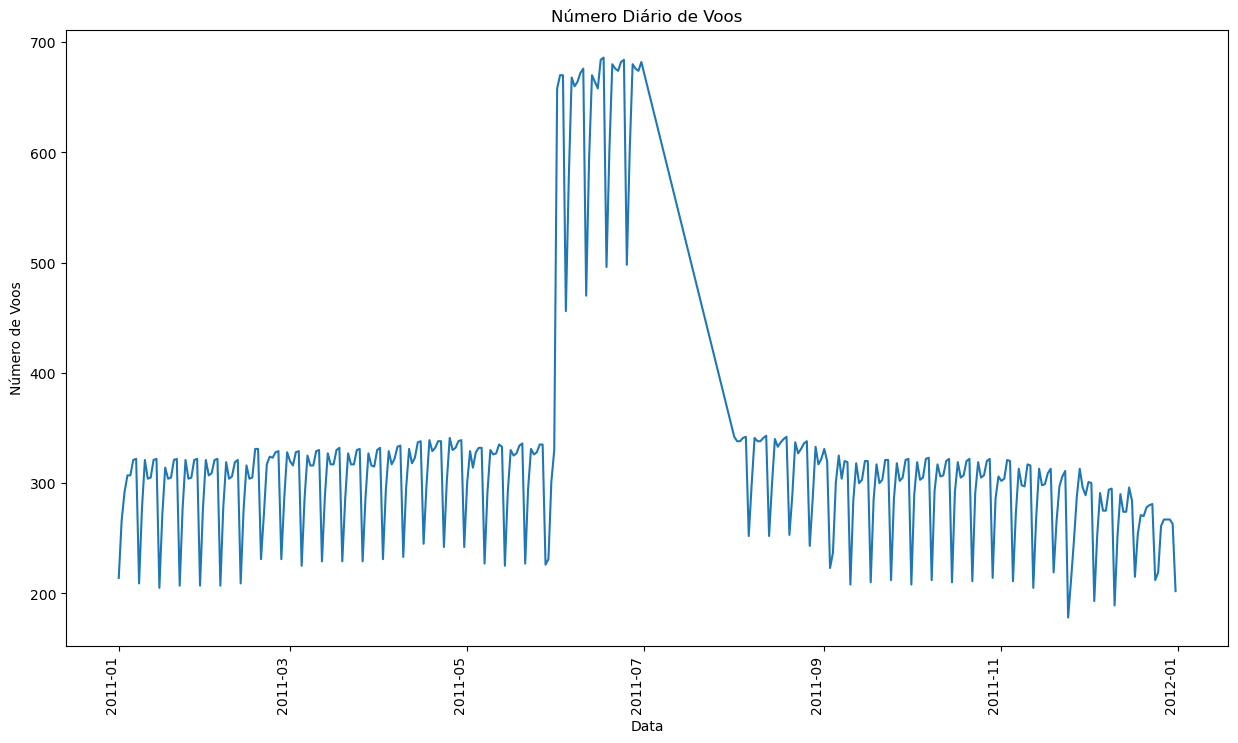

In [21]:
# # Plotando gráfico com o número de vôos diários

# plt.figure(figsize=(15,8))
# ax = sns.lineplot(data=df_BOS_agrupado_data_pandas, x='FL_DATE', y='count')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
# ax.set(title='Número Diário de Voos',
#        xlabel='Data',
#        ylabel='Número de Voos')

# plt.show()

## Usando Spark SQL

<font color = red> deixei os exemplos abaixo para fim de consulta de sintaxe <font>

In [24]:
#Registrando df como tabela de banco de dados relacional:
# df.createOrReplaceTempView("df")

In [19]:
# query = spark.sql(''' SELECT op_carrier,
#                              SUM(dep_delay),
#                              SUM(arr_delay),
#                              SUM(arr_delay + dep_delay)  as dep_arr_delay,  
#                              COUNT(FL_DATE) as count_fl_date,
#                              (SUM(arr_delay + dep_delay) / COUNT(FL_DATE)) as mean_dep_arr_delay 
#                       FROM df
#                       GROUP BY op_carrier
#                       ORDER BY mean_dep_arr_delay ASC
#                       ''' )

# query.show(10)

In [18]:
# query_abs = spark.sql(''' SELECT op_carrier, 
#                                  SUM(dep_delay),
#                                  SUM(arr_delay),
#                                  SUM( ABS(arr_delay) + ABS(dep_delay) )  as dep_arr_delay,  
#                                  COUNT(FL_DATE) as count_fl_date,
#                                  ( SUM( ABS(arr_delay) + ABS(dep_delay) ) / COUNT(FL_DATE) ) as mean_dep_arr_delay 
#                              FROM df
#                              GROUP BY op_carrier
#                              ORDER BY mean_dep_arr_delay ASC
#                              ''' )

# query_abs.show(10)

7. Qual aeroporto mais tem atrasos por questões de clima?

In [20]:
# query_weather_delay = spark.sql(''' SELECT op_carrier,
#                                            SUM(weather_delay) as sum_weather_delay    
#                                     From df
#                                     GROUP BY op_carrier
#                                     ORDER BY sum_weather_delay DESC
#                                     ''' )

# query_weather_delay.show(10)          

# 5.2. Análise Multivariada

<font color= red> plotar aqui gráfico de correlação <font>

# 6. Modelagem de Machine Learning

<font color = red> fazer aqui a separação entre treino e teste <font>

## 6.1. Modelo 1  

## 6.1. Modelo 2  

## 6.1. Modelo 3  